In [652]:
import sys, os
#base_path = os.path.abspath("../src/Deep_Features/")
#if not base_path in sys.path:
#    sys.path.append(base_path)

In [899]:
import numpy as np
import argparse
import json
from shutil import copyfile

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [900]:
config_path = '..'

In [901]:
config_path = '../src/Deep_Features/training_config.json'
if not os.path.isfile(config_path):
    #exit()
    print("Please provide training config.")
with open(config_path, "r") as config_file:
    config = json.loads(config_file.read())

In [902]:
if "region" in config:
    c = config["num_regions"]
else:
    c = 2


In [924]:
config['model'] = 'ResNet'

In [925]:
resume_hash = ""
if not len(resume_hash) == 0:
    training_hash = resume_hash
else:
    import hashlib
    import time
    training_hash = time.strftime("%Y_%m_%d_%H_%M_%S", time.gmtime())

In [926]:
window_str = f"{config['window_size']['x']}x{config['window_size']['y']}"
model_identifier = f"{config['model']}{config['model_size']}_{training_hash}"
model_savedir = f"../src/Deep_Features/results/trained_models/{model_identifier}"
if (not os.path.isdir(model_savedir)):
    os.mkdir(model_savedir)
model_savepath = os.path.join(model_savedir, f"{model_identifier}.pt")

summary_logdir = f"../src/Deep_Features/runs/{model_identifier}"
if (not os.path.isdir(summary_logdir)):
    os.mkdir(summary_logdir)
copyfile(config_path, os.path.join(model_savedir, "training_config.json"))
copyfile(config_path, os.path.join(summary_logdir, "training_config.json"))

'../src/Deep_Features/runs/ResNet6_2024_11_18_14_29_34/training_config.json'

In [927]:
size_window = (config['window_size']['y'], config['window_size']['x'])

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [928]:
# resume training if possible
if os.path.isfile(model_savepath):
    model.load_state_dict(torch.load(model_savepath))

In [929]:
import torch
import numpy as np
from PIL import Image
import os
from torch.utils import data
from skimage.util import view_as_windows
import glob

def get_first_training_files(train=True):
    if train:
        dset_files = read_vol_list("../src/Deep_Features/training_data.csv")
    else:
        dset_files = read_vol_list("testing_vols.csv")
    assert len(dset_files) > 0, "No valid volume data was provided."
    rel_path = dset_files[1]
    #print("rel_path",rel_path)
    path_train_im = rel_path[1][:-4]
    path_label_im = rel_path[2][:-4]
    return path_train_im, path_label_im

def build_data_loader(size_window, c, batch_size=32, debug=0, workers=4, single_pixel_out=True, train=True):
    """
    size_window:      Spatial shape of input data to model.
    debug:            In debug mode, only part of the data is loaded.
    single_voxel_out: Output is a single voxel label. This is in contrast to fully convolutional models which require a patch of voxels.
    """
    if not debug == 1:
        print('Enter')
        dataset = Multiple_Image_Patch_Dataset(size_window, c, single_pixel_out=single_pixel_out, train=train)
    else:
        fname, gt_fname = get_first_training_files(train)
        dataset = Image_Patch_Dataset(fname, gt_fname, size_window, c, single_pixel_out=single_pixel_out)
    return data.DataLoader(dataset, batch_size, shuffle=True, num_workers=workers)

class Multiple_Image_Patch_Dataset(data.Dataset):
    """
    Wraps multiple Image data files instances.
    """
    def __init__(self, size_window, c, single_pixel_out=True, train=True):
        """
        """
        self.dsets = []

        if train:
            dset_files = read_Image_list("../src/Deep_Features/training_data.csv")
        else:
            dset_files = read_Image_list("../src/Deep_Features/testing_data.csv")

        for path_train_im,path_label_im in dset_files[1:]:
            #print(f"The data path is {path_train_im}")
            #print(f"The data label path is {path_label_im}")
            assert path_train_im.endswith(".png")
            self.dsets.append(Image_Patch_Dataset(path_train_im, path_label_im, size_window, c, single_pixel_out=single_pixel_out))

    def __len__(self):
        return np.sum([len(ds) for ds in self.dsets])

    def __getitem__(self, idx):
        """
        """
        for ds in self.dsets:
            if idx >= len(ds):
                idx -= len(ds)
            else:
                return ds[idx]

class Image_Patch_Dataset(data.Dataset):
    """
    Loads training data from a single Image.
    """
    def __init__(self, data_path, labels_path, size_window, c, single_pixel_out=True):
        """
        """
        mask = np.array([0.299,0.587,0.114])/(255.0)
        self.raw_data = np.einsum('ijk,k->ij',np.array(Image.open(data_path).copy()).astype(np.double)[:,:,:],mask)
        self.size_window = size_window
        try:
            self.view = view_as_windows(self.raw_data, size_window)
        except:
            print(f"Failed to stride image {data_path} with shape {self.raw_data.shape} using window of size {size_window}. Skipping.")
            return
        self.view_spatial_shape = self.view.shape[:2]
        self.labels = np.array(Image.open(labels_path).copy())
        print(self.labels.shape)
        
        c_dat = int(self.labels.max()) + 1
        
        assert self.labels.min() == 0
        assert self.labels.max() == c-1
        assert not np.isnan(np.sum(self.labels))
        assert not np.isnan(np.sum(self.raw_data))
        
        self.single_pixel_out = single_pixel_out
        if single_pixel_out:
            rx, ry = (size_window[0] - 1)//2, (size_window[1] - 1)//2
            self.labels = self.labels[rx:-rx,ry:-ry]
            assert self.labels.shape == self.view_spatial_shape
        else:
            self.label_view = view_as_windows(self.labels, size_window)

    def __len__(self):
        return np.prod(self.view_spatial_shape)
    
    def __getitem__(self, idx):
        (x,y) = np.unravel_index(idx, self.view_spatial_shape)

        patch = self.view[x,y,:,:].reshape(self.size_window)
        if self.single_pixel_out:
            patch = patch.reshape((self.size_window))
            print(patch.shape)
            return torch.FloatTensor(patch), torch.LongTensor(self.labels[x,y].reshape((1,)))
        labels = self.label_view[x,y,:,:]
        #print("labels",labels.shape)
        #print("patch",patch.shape)
        return torch.FloatTensor(patch), torch.LongTensor(labels.reshape(self.size_window))

def read_Image_list(path):
    with open(path, "r") as f:
        lines = f.readlines()
    fpaths = [fn[:-1].split(',')[1:] if fn.endswith("\n") else fn for fn in lines]
    return fpaths

In [909]:
def build_activation(activation_name):
    activation_funcs = nn.ModuleDict([
        ['elu',         nn.ELU()],
        ['log_sigmoid', nn.LogSigmoid()],
        ['sigmoid',     nn.Sigmoid()],
        ['relu',        nn.ReLU()]
    ])
    return activation_funcs[activation_name]

class DenseBlock(nn.Module):
    def __init__(self, in_dim, out_dim, activation, dropout=0.0):
        super(DenseBlock, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.op = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.Dropout(dropout),
            build_activation(activation)
        )

    def forward(self, x):
        x = self.op(x)
        return x

class DenseNetwork(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dims, activation='relu', dropout=0.0):
        super(DenseNetwork, self).__init__()
        self.in_dim = in_dim
        self.activation = build_activation(activation)
        if len(hidden_dims) > 1:
            self.forward_op = nn.Sequential(
                DenseBlock(in_dim, hidden_dims[0], activation, dropout),
                *[DenseBlock(input_dim, output_dim, activation, dropout) for (input_dim, output_dim) in zip(hidden_dims[:-1],hidden_dims[1:])],
                DenseBlock(hidden_dims[-1], out_dim, activation, dropout)
            )
        elif len(hidden_dims) == 1:
            self.forward_op = nn.Sequential(
                DenseBlock(in_dim, hidden_dims[0], activation, dropout),
                DenseBlock(hidden_dims[0], out_dim, activation, dropout)
            )
        else:
            self.forward_op = DenseBlock(in_dim, out_dim, activation, dropout)

    def forward(self, x):
        x = self.forward_op(x.reshape((-1, self.in_dim)))
        return x

def generate_hidden_dims(size, in_dim):
    if size == 1:
        return []

    expansion = {
        2:  [1.5],
        6:  [1.5, 2.0, 1.5, 0.5],
        10: [1.5, 2.5, 5.0, 5.5, 3.5, 2.5, 1.5, 0.5],
        17: [1.5, 2.5, 5.0, 8.0, 10.0, 10.0, 8.0, 8.0, 5.0, 5.0, 5.0, 3.5, 2.5, 1.5, 0.5],
        23: [1.5, 2.5, 5.0, 8.0, 10.0, 15.0, 20.0, 20.0, 18.0, 15.0, 15.0, 12.0, 10.0, 10.0, 8.5, 5.5, 3.0, 3.0, 2.0, 1.0, 0.5],

    }
    assert size in expansion.keys(), f"Unsupported dense network size: {size}."
    return [int(ex*in_dim) for ex in expansion[size]]

def generate_small_hidden_dims(size, in_dim):
    if size == 1:
        return []

    expansion = {
        2:  [0.5],
        6:  [1.0, 0.8, 0.5, 0.2],
        10: [1.0, 1.0, 1.0, 0.8, 0.7, 0.5, 0.3, 0.2],
        17: [1.0, 1.0, 1.0, 1.2, 1.2, 1.5, 1.5, 1.2, 1.2, 1.0, 1.0, 0.8, 0.5, 0.3, 0.2],
        23: [1.0, 1.0, 1.0, 1.0, 1.2, 1.2, 1.5, 1.5, 1.8, 1.5, 1.2, 1.2, 1.0, 1.0, 0.8, 0.7, 0.6, 0.5, 0.5, 0.3, 0.2],

    }
    assert size in expansion.keys(), f"Unsupported dense network size: {size}."
    return [int(ex*in_dim) for ex in expansion[size]]

def dense_predictor(in_dim, out_dim, size, activation='relu', dropout=0.0):
    """
    Build dense NN model with large hidden dimension.
    """
    assert activation in ['elu', 'log_sigmoid', 'sigmoid', 'relu']
    return DenseNetwork(in_dim, out_dim, generate_hidden_dims(size, in_dim), activation=activation, dropout=dropout)

def flat_dense_predictor(in_dim, out_dim, size, activation='relu', dropout=0.0):
    """
    Build dense NN model with small hidden dimension.
    """
    assert activation in ['elu', 'log_sigmoid', 'sigmoid', 'relu']
    return DenseNetwork(in_dim, out_dim, generate_small_hidden_dims(size, in_dim), activation=activation, dropout=dropout)

In [930]:

import torch
import torch.nn as nn

from functools import partial

class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)  


def activation_func(activation):
    return  nn.ModuleDict([
        ['relu', nn.ReLU(inplace=True)],
        ['leaky_relu', nn.LeakyReLU(negative_slope=0.01, inplace=True)],
        ['selu', nn.SELU(inplace=True)],
        ['none', nn.Identity()]
    ])[activation]


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels,Features = False, activation='relu'):
        super().__init__()
        self.Features = Features
        self.in_channels, self.out_channels, self.activation = in_channels, out_channels, activation
        self.blocks = nn.Identity()
        self.activate = activation_func(activation)
        self.shortcut = nn.Identity()
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        x = self.activate(x)
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels


class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(
            nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            nn.BatchNorm2d(self.expanded_channels)) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(conv(in_channels, out_channels, *args, **kwargs), nn.BatchNorm2d(out_channels))


class ResNetBasicBlock(ResNetResidualBlock):
    """
    Basic ResNet block composed by two layers of 3x3conv/batchnorm/activation
    """
    expansion = 1
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation_func(self.activation),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )

class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation_func(self.activation),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
             activation_func(self.activation),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )

class ResNetLayer(nn.Module):
    """
    A ResNet layer composed by `n` blocks stacked one after the other
    """
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x


class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by layers with increasing features.
    """
    def __init__(self, in_channels=1, blocks_sizes=[64, 128, 256, 512], depths=[2,2,2,2], 
                 activation='relu', block=ResNetBasicBlock, *args, **kwargs):
        super().__init__()
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation_func(activation),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=depths[0], activation=activation, 
                        block=block,*args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, depths[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x


class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes,Features, dropout=0.0):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        if Features:
            self.decoder = nn.Sequential(
                nn.Dropout(p=1.0-dropout),
                nn.Identity(in_features)
            )
        else:
            self.decoder = nn.Sequential(
                nn.Dropout(p=1.0-dropout),
                nn.Linear(in_features, n_classes)
            )

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x


class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes,Features, dropout=0.0, *args, **kwargs):
        super().__init__()
        self.Features = Features
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes,Features, dropout)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def resnet(size, in_channels, n_classes,Feat, *args, **kwargs):
    layer_depths = {
        5:   [1, 1, 1, 1],
        6:   [1, 1, 1, 1],
        7:   [1, 1, 1, 1],
        8:   [1, 1, 1, 1],
        9:   [1, 1, 1, 1],
        10:  [1, 1, 1, 1],
        18:  [2, 2, 2, 2], 
        34:  [3, 4, 6, 3],
        50:  [3, 4, 6, 3],
        101: [3, 4, 23, 3],
        152: [3, 8, 36, 3]
    }
    blocks = {
        5:   ResNetBasicBlock,
        6:   ResNetBasicBlock,
        7:   ResNetBasicBlock,
        8:   ResNetBasicBlock,
        9:   ResNetBasicBlock,
        10:  ResNetBasicBlock,
        18:  ResNetBasicBlock,
        34:  ResNetBasicBlock,
        50:  ResNetBottleNeckBlock,
        101: ResNetBottleNeckBlock,
        152: ResNetBottleNeckBlock
    }
    channel_dims = {
        5:   [2, 4, 8, 16],
        6:   [4, 8, 16, 32],
        7:   [8, 16, 32, 64],
        8:   [16, 32, 64, 128],
        9:   [32, 64, 128, 256],
        10:  [64, 128, 256, 512],
        18:  [64, 128, 256, 512],
        34:  [64, 128, 256, 512],
        50:  [64, 128, 256, 512],
        101: [64, 128, 256, 512],
        152: [64, 128, 256, 512]
    }
    assert layer_depths.keys() == blocks.keys()
    assert size in layer_depths.keys()
    return ResNet(in_channels, n_classes,Features = Feat, block=blocks[size], blocks_sizes=channel_dims[size], depths=layer_depths[size], *args, **kwargs)

In [769]:
# With square kernels and equal stride
m = nn.Conv2d(16, 33, 3, stride=2)
# non-square kernels and unequal stride and with padding
m = nn.Conv2d(16, 33, 7,stride=1, padding=(0, 0))
# non-square kernels and unequal stride and with padding and dilation
#m = nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2), dilation=(3, 1))
input = torch.randn(20, 16, 50, 100)
output = m(input)

In [770]:
output.shape

torch.Size([20, 33, 44, 94])

In [931]:
model = resnet(config['model_size'], 1, c, dropout=config['dropout'],Feat=False)

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBasicBlock(
            (blocks): Sequential(
              (0): Sequential(
                (0): Conv2dAuto(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU(inplace=True)
              (2): Sequential(
                (0): Conv2dAuto(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, tr

In [897]:
model(data[0][:,None,:,:]).shape

torch.Size([32, 2])

In [585]:
mask = np.array([0.299,0.587,0.114])/(255.0)
vol = np.einsum('ijk,k->ij',np.array(Image.open(D_Train['Train_Path'][0]).copy()).astype(np.double)[:,:,:],mask)

In [932]:


#if config['model'] == 'dense':
#    from model_dense import dense_predictor
##model = dense_predictor(int(np.prod(size_window)), c, size=config['model_size'], activation=config['activation'], dropout=config['dropout'])

fully_convolutional = (config['model'] in ['ResNet'])
model.to(device)

train_dataloader = build_data_loader(size_window, c,
    train=True,
    batch_size=config['batch_size'],
    workers=config['workers_training'],
    single_pixel_out=(not fully_convolutional))

test_dataloader = build_data_loader(
    size_window, c,
    train=False,
    batch_size=config['batch_size'],
    workers=config['workers_testing'],
    single_pixel_out=(not fully_convolutional))
test_iter = iter(test_dataloader)



Enter
(314, 350)
(348, 406)
(507, 800)
(574, 800)
(248, 479)
(264, 336)
(272, 300)
(480, 640)
(253, 300)
(293, 350)
Enter
(590, 800)
(212, 269)
(198, 297)
(375, 479)
(346, 400)
(251, 226)
(348, 524)
(195, 309)
(201, 300)
(279, 304)
(508, 560)


In [349]:
size_window

(8, 8)

In [661]:
i = 0
for i, data in enumerate(train_dataloader, 0):
    if i ==1:
        break

In [351]:
criterion = nn.CrossEntropyLoss()

In [662]:
data[0].shape

torch.Size([32, 8, 8])

In [353]:
Input = Input.unsqueeze(1)

In [578]:
data[0].shape

torch.Size([32, 8, 8])

In [576]:
output

tensor([[1.8169, 0.1023],
        [1.1752, 0.0000],
        [1.2001, 0.0000],
        [0.7847, 0.0000],
        [1.1600, 0.0000],
        [1.5187, 0.0221],
        [1.1140, 0.0000],
        [1.1553, 0.0000],
        [1.0912, 0.0000],
        [1.1861, 0.0000],
        [1.1393, 0.0000],
        [1.0667, 0.0000],
        [1.5670, 0.0355],
        [1.1333, 0.0000],
        [0.9956, 0.0000],
        [1.6194, 0.0494],
        [1.5315, 0.0262],
        [1.5448, 0.0293],
        [1.1981, 0.0000],
        [1.1396, 0.0000],
        [1.5592, 0.0336],
        [1.4577, 0.0065],
        [1.4531, 0.0054],
        [1.4693, 0.0093]], grad_fn=<ReluBackward0>)

In [207]:
target = target.unsqueeze(1)


In [79]:
data[1].shape

torch.Size([14, 8, 8])

In [75]:
outputs = torch.squeeze(output, dim=0)

In [181]:
target = target[:,1:-1,1:-1]

In [542]:
data[0].shape

torch.Size([24, 8, 8])

In [236]:
criterion(output,target[:,0,0])

tensor(0.6993, grad_fn=<NllLossBackward0>)

In [ ]:
# Training Part 
debug = 0
from torch.utils.tensorboard import SummaryWriter

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

if not debug == 1:
    writer = SummaryWriter(summary_logdir)

log_interval = int(1e3)
save_interval = int(1e4)
num_test_batches = 20

running_loss = 0.0

for epoch in range(10):  # loop over the dataset multiple times

    for i, data in enumerate(train_dataloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        if fully_convolutional:
            # add channel dimension
            inputs = inputs.unsqueeze(1)
        else:
            labels = labels.flatten()
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        if fully_convolutional:
            # remove channel dimension
            outputs = torch.squeeze(outputs, dim=1)
        loss = criterion(outputs, labels[:,0,0])
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % log_interval == log_interval-1:
            print(f"batch {i} training loss {running_loss / log_interval}")
            if not debug == 1:
                writer.add_scalar('training_loss', running_loss / log_interval, epoch*len(train_dataloader) + i)
            running_loss = 0.0

            # run testing
            model.eval()
            test_loss = 0.0
            for test_batches in range(num_test_batches):
                try:
                    test_data, test_labels = next(test_iter)
                except StopIteration:
                    test_iter = iter(test_dataloader)
                    test_data, test_labels = next(test_iter)
                if fully_convolutional:
                    test_data = test_data.unsqueeze(1)
                else:
                    test_labels = test_labels.flatten()
                test_data = test_data.to(device)
                test_labels = test_labels.to(device)
                test_out = model(test_data)
                if fully_convolutional:
                    test_out = torch.squeeze(test_out, 1)
                test_loss += criterion(test_out, test_labels[:,0,0]).item()
            print(f"batch {i} testing loss {test_loss / num_test_batches}")
            if not debug == 1:
                writer.add_scalar('testing_loss', test_loss / num_test_batches, epoch*len(train_dataloader) + i)
            model.train()

        if i % save_interval == save_interval-1:
            if not debug == 1:
                print("Saving model...")
                torch.save(model.state_dict(), model_savepath)

    print("Finished epoch. Saving model...")
    if not debug == 1:
        torch.save(model.state_dict(), model_savepath)

print('Finished Training')

batch 999 training loss 0.5916938357651234
batch 999 testing loss 0.5931442558765412
batch 1999 training loss 0.5960625706017018
batch 1999 testing loss 0.5582581639289856
batch 2999 training loss 0.5891269073784351
batch 2999 testing loss 0.5925014987587929
batch 3999 training loss 0.5901298831701278
batch 3999 testing loss 0.5883576586842537
batch 4999 training loss 0.5822337490320205
batch 4999 testing loss 0.5894098103046417
batch 5999 training loss 0.5904708070755005
batch 5999 testing loss 0.6633719474077224
batch 6999 training loss 0.583620659261942
batch 6999 testing loss 0.6400160849094391
batch 7999 training loss 0.5915556504130364
batch 7999 testing loss 0.5866793856024742
batch 8999 training loss 0.5849824759960175
batch 8999 testing loss 0.5511281207203865
batch 9999 training loss 0.5927414185106754
batch 9999 testing loss 0.5817134156823158
Saving model...
batch 10999 training loss 0.5892316866219044
batch 10999 testing loss 0.5661485224962235
batch 11999 training loss 0.

In [547]:
model()

TypeError: forward() missing 1 required positional argument: 'x'

In [915]:
from tqdm import tqdm
from skimage.util import view_as_blocks

mask = np.array([0.299,0.587,0.114])/(255.0)
vol = np.einsum('ijk,k->ij',np.array(Image.open(D_Train['Train_Path'][5]).copy()).astype(np.double)[:,:,:],mask)

window_size = (8,8)
batch_size = 32
overlap_windows = 3
model.eval()
if fully_convolutional:
    assert 2*overlap_windows < min(*window_size)
    inner_window_size = tuple([ws-2*overlap_windows for ws in window_size])
    # crop vol to make it compatible with windowig stride
    block_count = [(vs - 2*overlap_windows) // iws for vs, iws in zip(vol.shape, inner_window_size)]
    vol_shape = tuple([b*iws + 2*overlap_windows for b, iws in zip(block_count, inner_window_size)])
    vol = vol[:vol_shape[0],:vol_shape[1]]
    
    # gather windows for prediction
    patches = view_as_windows(vol, window_size, step=inner_window_size).reshape((-1,*window_size))
    cropped_vol_shape = tuple([vs - 2*overlap_windows for vs in vol.shape])
    scores = np.empty((*cropped_vol_shape, c), dtype=np.float32)
    scores_view = view_as_blocks(scores, (*inner_window_size, c))
    
    for batch_ind in tqdm(range(1 + patches.shape[0] // batch_size)):
        batch_input = torch.FloatTensor(patches[batch_ind*batch_size:(batch_ind+1)*batch_size,...]).to(device)
        if batch_input.shape[0] == 0:
            continue
        predictions = model(batch_input[:,None,:,:]).data.cpu().numpy()

        for i, ind in enumerate(range(batch_ind*batch_size, (batch_ind+1)*batch_size)):
            if i < predictions.shape[0]:
                block_ind = np.unravel_index(ind, scores_view.shape[:2])
                scores_view[block_ind[0],block_ind[1],0,...] = predictions[i,:]

dist = - scores
dist -= dist.min()
dist /= dist.max()


100%|██████████| 666/666 [00:02<00:00, 230.58it/s]


(-0.5, 329.5, 257.5, -0.5)

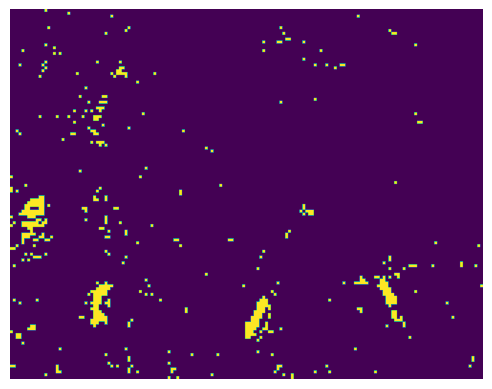

In [918]:
plt.imshow(np.argmin(dist,axis=2))
plt.axis('off')

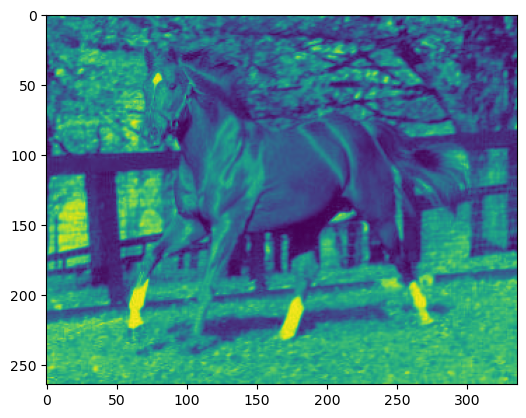

In [917]:
plt.imshow(vol)

In [73]:

for epoch in range(100):  # loop over the dataset multiple times

    for i, data in enumerate(train_dataloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        if fully_convolutional:
            # add channel dimension
            inputs = inputs.unsqueeze(1)
        else:
            labels = labels.flatten()
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        if fully_convolutional:
            # remove channel dimension
            outputs = torch.squeeze(outputs, dim=1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % log_interval == log_interval-1:
            print(f"batch {i} training loss {running_loss / log_interval}")
            if not args.debug == 1:
                writer.add_scalar('training_loss', running_loss / log_interval, epoch*len(train_dataloader) + i)
            running_loss = 0.0

            # run testing
            model.eval()
            test_loss = 0.0
            for test_batches in range(num_test_batches):
                try:
                    test_data, test_labels = next(test_iter)
                except StopIteration:
                    test_iter = iter(test_dataloader)
                    test_data, test_labels = next(test_iter)
                if fully_convolutional:
                    test_data = test_data.unsqueeze(1)
                else:
                    test_labels = test_labels.flatten()
                test_data = test_data.to(device)
                test_labels = test_labels.to(device)
                test_out = model(test_data)
                if fully_convolutional:
                    test_out = torch.squeeze(test_out, 1)
                test_loss += criterion(test_out, test_labels).item()
            print(f"batch {i} testing loss {test_loss / num_test_batches}")
            if not args.debug == 1:
                writer.add_scalar('testing_loss', test_loss / num_test_batches, epoch*len(train_dataloader) + i)
            model.train()

        if i % save_interval == save_interval-1:
            if not args.debug == 1:
                print("Saving model...")
                torch.save(model.state_dict(), model_savepath)

    print("Finished epoch. Saving model...")
    if not args.debug == 1:
        torch.save(model.state_dict(), model_savepath)

print('Finished Training')

The training data path is ../../FM_Eikonal/data/weizmann_horse_db/horse/horse001.png
The training data label path is ../../FM_Eikonal/data/weizmann_horse_db/mask//horse001.png
The training data path is ../../FM_Eikonal/data/weizmann_horse_db/horse/horse002.png
The training data label path is ../../FM_Eikonal/data/weizmann_horse_db/mask//horse002.png
The training data path is ../../FM_Eikonal/data/weizmann_horse_db/horse/horse004.png
The training data label path is ../../FM_Eikonal/data/weizmann_horse_db/mask//horse004.png
The training data path is ../../FM_Eikonal/data/weizmann_horse_db/horse/horse005.png
The training data label path is ../../FM_Eikonal/data/weizmann_horse_db/mask//horse005.png
The training data path is ../../FM_Eikonal/data/weizmann_horse_db/horse/horse007.png
The training data label path is ../../FM_Eikonal/data/weizmann_horse_db/mask//horse007.png
The training data path is ../../FM_Eikonal/data/weizmann_horse_db/horse/horse008.png
The training data label path is ../

In [561]:
import pandas as pd

Train = pd.DataFrame()
' Splitt the data Set into two sets for training and for testing '

Ind = np.random.choice(327,10)
Train_Paths = []
Train_Paths_Labels = []
Num_List = []

for im_num in Ind:
    Num_List.append(im_num)
    if len(str(im_num)) == 3:
        path_1 = '../../FM_Eikonal/data/weizmann_horse_db/horse/horse'+str(im_num)+".png"
        path_2 = '../../FM_Eikonal/data/weizmann_horse_db/mask//horse'+str(im_num)+".png"
        Train_Paths.append(path_1)
        Train_Paths_Labels.append(path_2)
    elif len(str(im_num)) == 2:
        path_1 = '../../FM_Eikonal/data/weizmann_horse_db/horse/horse0'+str(im_num)+".png"
        path_2 = '../../FM_Eikonal/data/weizmann_horse_db/mask//horse0'+str(im_num)+".png"
        Train_Paths.append(path_1)
        Train_Paths_Labels.append(path_2)
    elif len(str(im_num)) == 1 and im_num != 0:
        path_1 = '../../FM_Eikonal/data/weizmann_horse_db/horse/horse00'+str(im_num)+".png"
        path_2 = '../../FM_Eikonal/data/weizmann_horse_db/mask//horse00'+str(im_num)+".png"
        Train_Paths.append(path_1)
        Train_Paths_Labels.append(path_2)

' Train_Set '
D_Train = pd.DataFrame({'Train_Path':Train_Paths,'Train_Path_Labels':Train_Paths_Labels})

In [562]:

' Test_Set '
Test_Paths = []
Test_Paths_Labels = []
for k in range(1,327):
    if k not in Num_List:
        if len(str(k)) == 3:
            path_1 = '../../FM_Eikonal/data/weizmann_horse_db/horse/horse'+str(k)+".png"
            path_2 = '../../FM_Eikonal/data/weizmann_horse_db/mask//horse'+str(k)+".png"
            Test_Paths.append(path_1)
            Test_Paths_Labels.append(path_2)
        elif len(str(k)) == 2:
            path_1 = '../../FM_Eikonal/data/weizmann_horse_db/horse/horse0'+str(k)+".png"
            path_2 = '../../FM_Eikonal/data/weizmann_horse_db/mask//horse0'+str(k)+".png"
            Test_Paths.append(path_1)
            Test_Paths_Labels.append(path_2)
        elif len(str(k)) == 1 and im_num != 0:
            path_1 = '../../FM_Eikonal/data/weizmann_horse_db/horse/horse00'+str(k)+".png"
            path_2 = '../../FM_Eikonal/data/weizmann_horse_db/mask//horse00'+str(k)+".png"
            Test_Paths.append(path_1)
            Test_Paths_Labels.append(path_2)
        if k >10:
            break
        
D_Test = pd.DataFrame({'Test_Path':Test_Paths,'Test_Path_Labels':Test_Paths_Labels})

In [563]:
D_Train.to_csv('../src/Deep_Features/training_data.csv')
D_Test.to_csv('../src/Deep_Features/testing_data.csv')


In [428]:
D_Test['Test_Path']

0     ../../FM_Eikonal/data/weizmann_horse_db/horse/...
1     ../../FM_Eikonal/data/weizmann_horse_db/horse/...
2     ../../FM_Eikonal/data/weizmann_horse_db/horse/...
3     ../../FM_Eikonal/data/weizmann_horse_db/horse/...
4     ../../FM_Eikonal/data/weizmann_horse_db/horse/...
5     ../../FM_Eikonal/data/weizmann_horse_db/horse/...
6     ../../FM_Eikonal/data/weizmann_horse_db/horse/...
7     ../../FM_Eikonal/data/weizmann_horse_db/horse/...
8     ../../FM_Eikonal/data/weizmann_horse_db/horse/...
9     ../../FM_Eikonal/data/weizmann_horse_db/horse/...
10    ../../FM_Eikonal/data/weizmann_horse_db/horse/...
11    ../../FM_Eikonal/data/weizmann_horse_db/horse/...
12    ../../FM_Eikonal/data/weizmann_horse_db/horse/...
13    ../../FM_Eikonal/data/weizmann_horse_db/horse/...
14    ../../FM_Eikonal/data/weizmann_horse_db/horse/...
15    ../../FM_Eikonal/data/weizmann_horse_db/horse/...
16    ../../FM_Eikonal/data/weizmann_horse_db/horse/...
17    ../../FM_Eikonal/data/weizmann_horse_db/ho

# UNET Model

In [697]:
import torch.nn as nn

class LinearPredictor(nn.Module):
	"""
	"""
	def __init__(self, in_dim, out_dim):
		super(LinearPredictor, self).__init__()
		self.in_dim = in_dim
		self.linear_op = nn.Linear(in_dim, out_dim)

	def forward(self, x):
		x = self.linear_op(x.reshape((-1, self.in_dim)))
		return x

def linear_predictor(in_dim, out_dim):
	return LinearPredictor(in_dim, out_dim)

In [698]:
model = linear_predictor(int(np.prod(size_window)), c)
model

LinearPredictor(
  (linear_op): Linear(in_features=64, out_features=2, bias=True)
)

In [701]:
model(data[0])

tensor([[ 0.0024, -0.0931],
        [ 0.0438, -0.1351],
        [-0.1378, -0.0772],
        [-0.0529, -0.0639],
        [ 0.0286, -0.0627],
        [ 0.0005, -0.0141],
        [-0.0656, -0.0208],
        [-0.0633, -0.0611],
        [ 0.1784, -0.1338],
        [ 0.0134, -0.0677],
        [ 0.0254, -0.0833],
        [ 0.0094, -0.0410],
        [-0.0277, -0.0627],
        [ 0.0997, -0.0294],
        [-0.0303, -0.0352],
        [ 0.0375, -0.0977],
        [-0.0243, -0.0341],
        [-0.0653, -0.0612],
        [-0.0384, -0.0383],
        [ 0.0147, -0.1102],
        [ 0.0523, -0.0807],
        [-0.0008, -0.0241],
        [-0.0323, -0.1087],
        [-0.0810, -0.0213],
        [ 0.0399, -0.0621],
        [ 0.0153, -0.0074],
        [ 0.0128, -0.0829],
        [-0.0064, -0.0492],
        [-0.0137, -0.0232],
        [ 0.0066, -0.0842],
        [-0.0165, -0.0823],
        [ 0.0158, -0.1204]], grad_fn=<AddmmBackward0>)

In [688]:
Relu(data[0][:,0,0].unsqueeze(0))

torch.Size([1, 32])

In [692]:
m = nn.ReLU()
input = torch.randn(2).unsqueeze(0)
output = torch.cat((m(input), m(-input)))

In [693]:
input

tensor([[ 0.3380, -0.1105]])

In [696]:
output[0]

tensor([0.3380, 0.0000])

In [127]:
for path_train_im,path_label_im in dset_files[1:]:
    print(f"The training data path is {path_train_im[:-4]}")
    print(f"The training data label path is {path_label_im[:-4]}")
    assert path_train_im.endswith(".png")
    path_train_im = rel_path[1][:-4]
    path_label_im = rel_path[2][:-4]
    self.dsets.append((path_train_im, path_label_im, size_window, c, single_voxel_out=single_voxel_out))

The training data path is ../../FM_Eikonal/data/weizmann_horse_db/horse/horse058
The training data label path is ../../FM_Eikonal/data/weizmann_horse_db/mask//horse058
The training data path is ../../FM_Eikonal/data/weizmann_horse_db/horse/horse187
The training data label path is ../../FM_Eikonal/data/weizmann_horse_db/mask//horse187
The training data path is ../../FM_Eikonal/data/weizmann_horse_db/horse/horse319
The training data label path is ../../FM_Eikonal/data/weizmann_horse_db/mask//horse319
The training data path is ../../FM_Eikonal/data/weizmann_horse_db/horse/horse309
The training data label path is ../../FM_Eikonal/data/weizmann_horse_db/mask//horse309
The training data path is ../../FM_Eikonal/data/weizmann_horse_db/horse/horse126
The training data label path is ../../FM_Eikonal/data/weizmann_horse_db/mask//horse126
The training data path is ../../FM_Eikonal/data/weizmann_horse_db/horse/horse113
The training data label path is ../../FM_Eikonal/data/weizmann_horse_db/mask//h

In [610]:
channel_sequences = {
		0: [1, 64, 128, 256, 512, 1024],
		1: [1,  2,   4,   8,  16,   32],
		2: [1,  4,   8,  16,  32,   64],
		3: [1,  8,  16,  32,  64,  128],
		4: [1, 16,  32,  64, 128,  256],
		5: [1, 32,  64, 128, 256,  512]
	}

dict_values([[1, 64, 128, 256, 512, 1024], [1, 2, 4, 8, 16, 32], [1, 4, 8, 16, 32, 64], [1, 8, 16, 32, 64, 128], [1, 16, 32, 64, 128, 256], [1, 32, 64, 128, 256, 512]])